In [18]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix 
import omnipath as op
import matplotlib.patches as mpatches

import sys 
sys.path.append('../../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
import captum

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 
from src.interpret.plot_explanation_graph import plot_explanation_graph, plot_hairball

from src.prioritize.utils import get_base_X, dose2scale, set_drug_concs
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Computing Edge Importance Scores 



In [19]:
siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [20]:
tnbc_vs_nonbreast_combo = pd.read_csv('../../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals_combo/TNBC_vs_nonbreast.csv')
druginfo = pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t')
pert2cmap = druginfo[['cmap_name', 'pert_id']].drop_duplicates()
tnbc_vs_nonbreast_combo = tnbc_vs_nonbreast_combo.merge(pert2cmap, left_on='pert_id_1', right_on='pert_id')
tnbc_vs_nonbreast_combo = tnbc_vs_nonbreast_combo.merge(pert2cmap, left_on='pert_id_2', right_on='pert_id')
tnbc_vs_nonbreast_combo = tnbc_vs_nonbreast_combo[lambda x: (x.p_sens > 0.95)].sort_values('diff_mean')
tnbc_vs_nonbreast_combo.head()

pert_id_1  dose_um_1      pert_id_2  dose_um_2  diff_mean  diff_var  \
616   BRD-K11528507       0.10  BRD-K60230970       0.10  -0.404180  0.023445   
1536  BRD-K11528507       0.10  BRD-K78659596       0.10  -0.378871  0.025106   
3805  BRD-A58767537       0.01  BRD-K23499943       0.10  -0.350522  0.017003   
5331  BRD-K23499943       0.10  BRD-K66175015       0.01  -0.338815  0.019815   
7339  BRD-A58767537       0.01  BRD-A61304759       0.10  -0.326734  0.015717   

      p_sens   cmap_name_x      pert_id_x   cmap_name_y      pert_id_y  
616    0.996  geldanamycin  BRD-K11528507        MG-132  BRD-K60230970  
1536   0.994  geldanamycin  BRD-K11528507      ixazomib  BRD-K78659596  
3805   0.994      afatinib  BRD-A58767537  alvespimycin  BRD-K23499943  
5331   0.986  alvespimycin  BRD-K23499943      afatinib  BRD-K66175015  
7339   0.989      afatinib  BRD-A58767537  tanespimycin  BRD-A61304759

In [21]:
# used for Edge Importance Scores model 
# model = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/model-100.pt').cpu().eval()
# data = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/Data.pt')
# proc = '../output/exp1/proc/'

model = torch.load('../../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt').cpu().eval()
data = torch.load('../../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/Data.pt')
proc = '../../output/exp1/proc/'


In [22]:
cell_x_dict = {cell:get_base_X([cell], proc, data, siginfo) for cell in data.cellspace}

In [30]:
# choose drug + cell line 

targ_line = 'BT20' 
back_line = 'BT20'

# BRD-A58767537	afatinib	BRD-K23499943	alvespimycin < - combo effective in TNBC vs nonTNBC + TNBC vs nonbreast 
targ_drugs = ['BRD-A58767537', 'BRD-K23499943']
targ_doses = [5., 5.]

back_drugs = []
back_doses = []

xx_no_drug = cell_x_dict[targ_line].detach().clone()
xx0_no_drug = cell_x_dict[back_line].detach().clone()

xx = set_drug_concs(xx_no_drug, targ_drugs, targ_doses, data)
print()
xx0 = set_drug_concs(xx0_no_drug, back_drugs, back_doses, data)

setting drug conc:  BRD-A58767537 5.0
setting drug conc:  BRD-K23499943 5.0



In [31]:
yyhat = model.cpu()(xx.unsqueeze(-1))
yy0hat = model.cpu()(xx0.unsqueeze(-1))

min_ = min(torch.min(yyhat), torch.min(yy0hat)).item()
max_ = max(torch.max(yyhat), torch.max(yy0hat)).item()

plt.figure()
plt.plot(yyhat.detach().cpu().numpy().ravel(), yy0hat.detach().cpu().numpy().ravel(), 'k.', label=f'r2={r2_score(yyhat.detach().cpu().numpy().ravel(), yy0hat.detach().cpu().numpy().ravel()):.2f}')
plt.legend(loc='upper right')
plt.plot((min_,max_), (min_,max_), 'b--')
plt.xlabel('Target Prediction')
plt.xlabel('Background Prediction')
plt.show()

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [32]:
explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=2000, lr=1e-2, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=500)

res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=xx0.unsqueeze(-1), x=xx.unsqueeze(-1), return_predictions=True)

iter: 1999 | mse: 2.75652862 | r2: 0.451 | active edges: 805.00
Final r2 (MLE): 0.43047999139386484


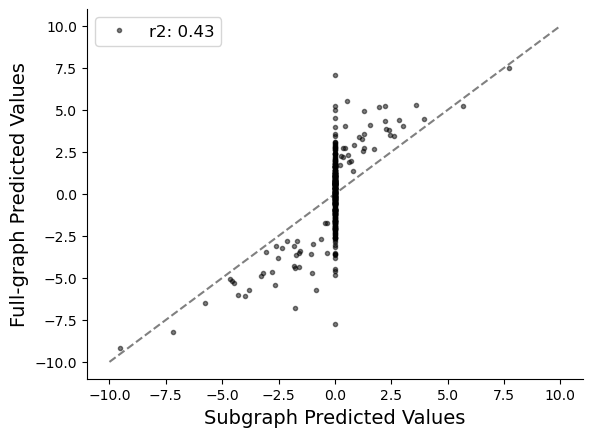

In [33]:
ax = plt.subplot(111)
ax.plot((-10, 10), (-10, 10), c='gray', linestyle='--') 
ax.plot(subgraph_preds, full_graph_preds, 'k.', label=f'r2: {r2:.2f}', alpha=0.5) 
ax.set_xlabel('Subgraph Predicted Values', fontsize=14)
ax.set_ylabel('Full-graph Predicted Values', fontsize=14)
plt.legend(fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [34]:
res[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)

source           target     score
11508  DRUG__BRD-K23499943  PROTEIN__P07900  0.999881
11277  DRUG__BRD-A58767537  PROTEIN__P00533  0.999825
11278  DRUG__BRD-A58767537  PROTEIN__P04626  0.988351
11916  DRUG__BRD-K64052750  PROTEIN__P28482  0.000312
11260  DRUG__BRD-A42649439  PROTEIN__P31751  0.000309
11985  DRUG__BRD-K67868012  PROTEIN__P42345  0.000307
11304  DRUG__BRD-A85667082  PROTEIN__Q92731  0.000306
12342  DRUG__BRD-K92441787  PROTEIN__P37231  0.000305
11668  DRUG__BRD-K42728290  PROTEIN__P22455  0.000304
12398  DRUG__BRD-K99964838  PROTEIN__P06213  0.000304

In [35]:
src_prots = [x.split('__') for x in res[lambda x: (x.score > 0.5) & (x.source.str.contains('PROTEIN__'))].source.values]
dst_prots = [x.split('__') for x in res[lambda x: (x.score > 0.5) & (x.target.str.contains('PROTEIN__'))].target.values]
prots = np.unique(src_prots + dst_prots)
print('# prots:', len(prots))
gene2uni = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')
prots_symb = gene2uni[lambda x: x.From.isin(prots)].To.unique()


#_ = [print(x) for x in (prots_symb.tolist())]

# prots: 132


full graph size: 345
largest comp. subgraph 337


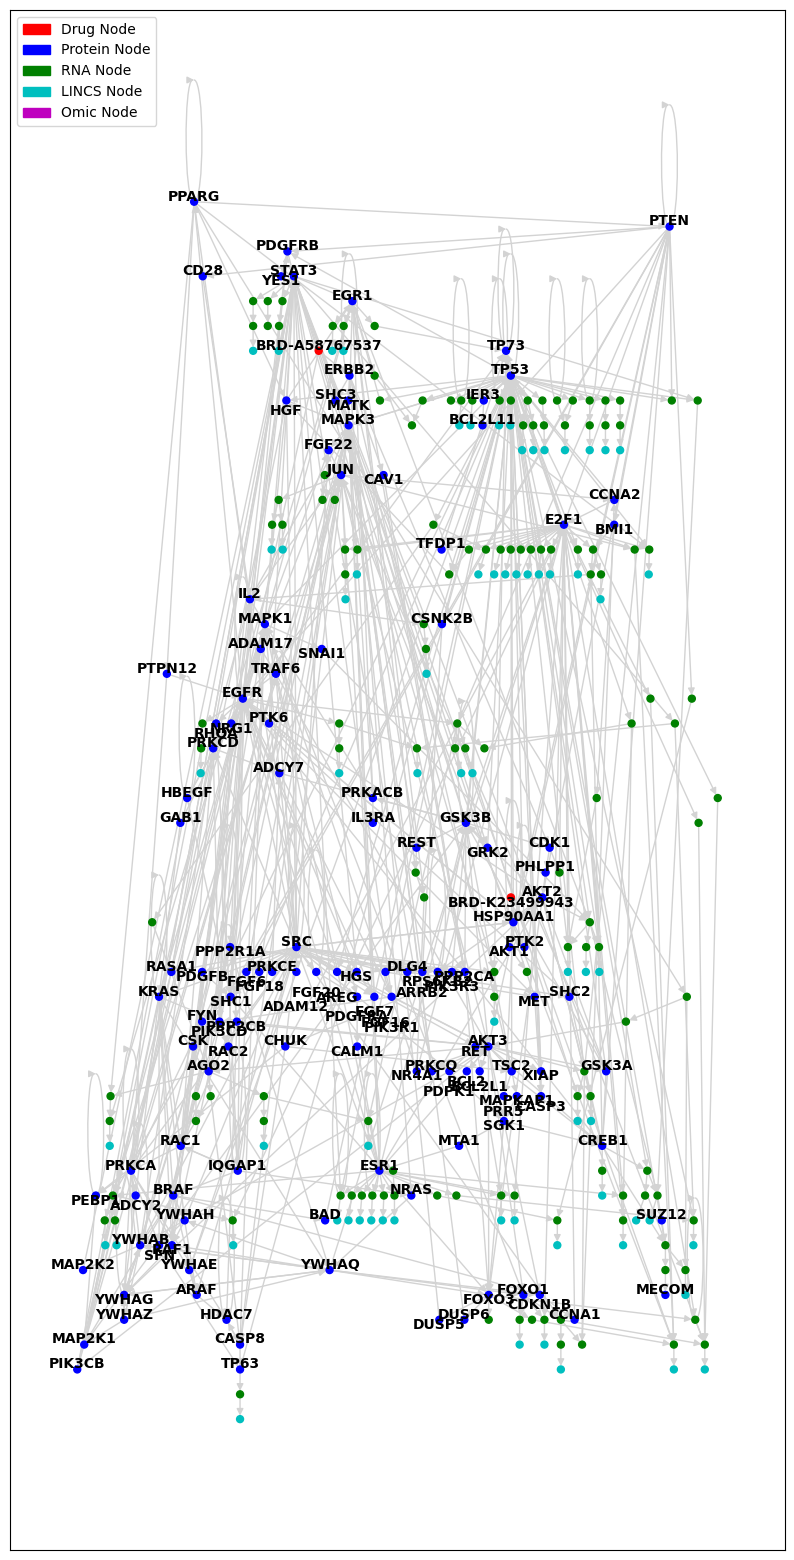

In [36]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10, extdata_path='../../extdata/')

# Undertanding difference between two cell lines predictions 

In [37]:
# choose drug + cell line 

targ_line = 'BT20'  # TNBC 
back_line = 'BT474' # Triple Positive 

# BRD-A58767537	afatinib	BRD-K23499943	alvespimycin < - combo effective in TNBC vs nonTNBC + TNBC vs nonbreast 
targ_drugs = ['BRD-A58767537', 'BRD-K23499943']
targ_doses = [1., 1.]

back_drugs = ['BRD-A58767537', 'BRD-K23499943']
back_doses = [1., 1.]

xx_no_drug = cell_x_dict[targ_line].detach().clone()
xx0_no_drug = cell_x_dict[back_line].detach().clone()

xx = set_drug_concs(xx_no_drug, targ_drugs, targ_doses, data)
print()
xx0 = set_drug_concs(xx0_no_drug, back_drugs, back_doses, data)

setting drug conc:  BRD-A58767537 1.0
setting drug conc:  BRD-K23499943 1.0

setting drug conc:  BRD-A58767537 1.0
setting drug conc:  BRD-K23499943 1.0


In [38]:
explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=2000, lr=1e-2, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=500)

res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=xx0.unsqueeze(-1), x=xx.unsqueeze(-1), return_predictions=True)

iter: 1999 | mse: 1.34206724 | r2: 0.277 | active edges: 493.00
Final r2 (MLE): 0.2502639765443684


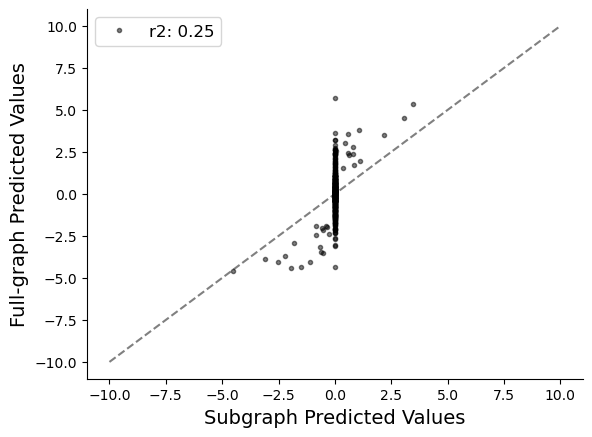

In [39]:
ax = plt.subplot(111)
ax.plot((-10, 10), (-10, 10), c='gray', linestyle='--') 
ax.plot(subgraph_preds, full_graph_preds, 'k.', label=f'r2: {r2:.2f}', alpha=0.5) 
ax.set_xlabel('Subgraph Predicted Values', fontsize=14)
ax.set_ylabel('Full-graph Predicted Values', fontsize=14)
plt.legend(fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

full graph size: 364
largest comp. subgraph 298


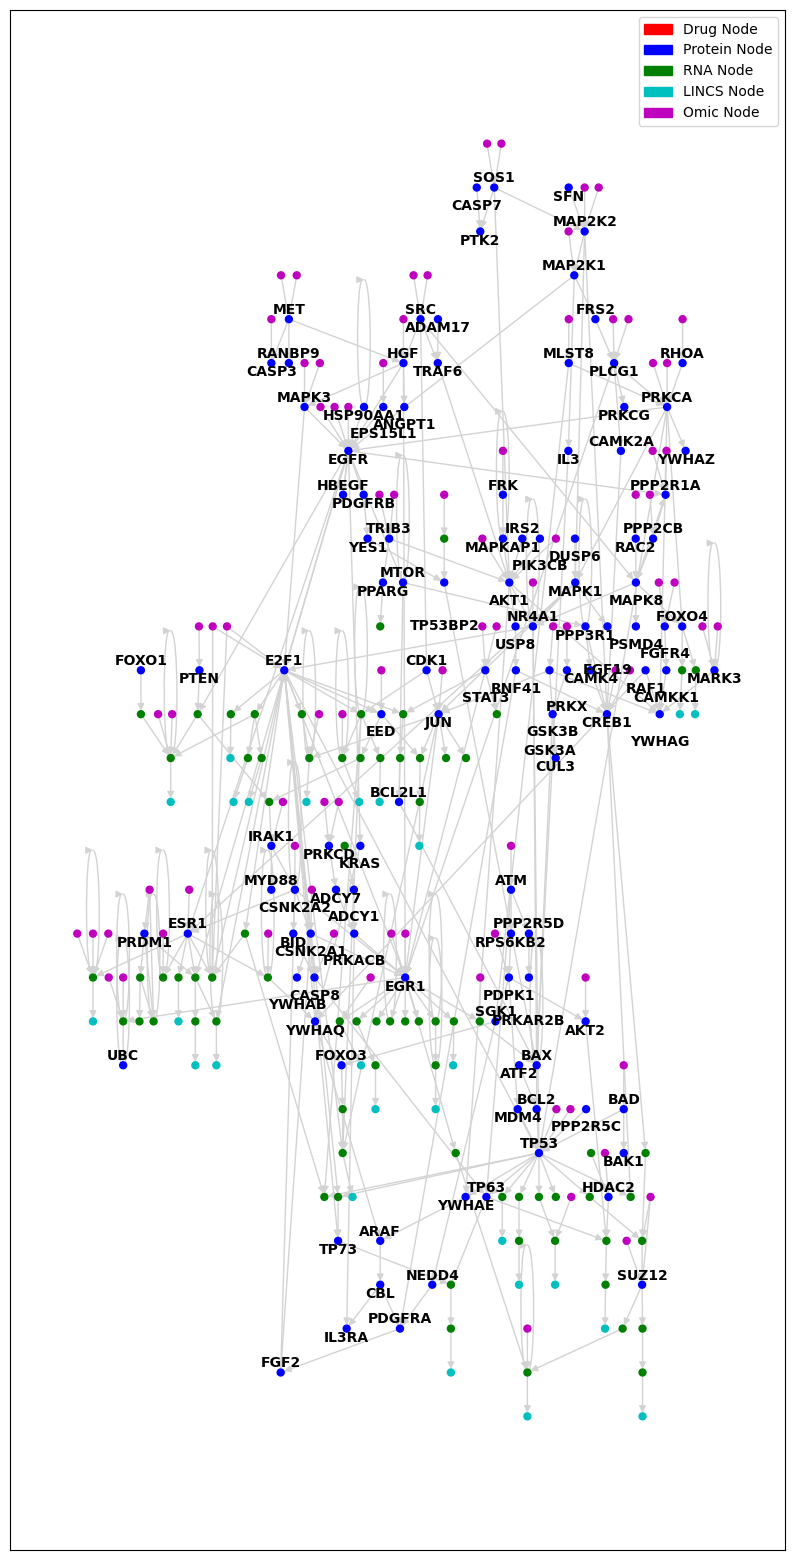

In [40]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10, extdata_path='../../extdata/')

In [57]:
res[['source_type' , 'source_uniprot']] = res.source.str.split('__', expand=True)
res[['target_type' , 'target_uniprot']] = res.target.str.split('__', expand=True)
res = res.merge(gene2uni.rename({'To':'source_gene_name'},axis=1), left_on='source_uniprot', right_on='From')
res = res.merge(gene2uni.rename({'To':'target_gene_name'},axis=1), left_on='target_uniprot', right_on='From')
res.head()

Passing 'suffixes' which cause duplicate columns {'From_x'} in the result is deprecated and will raise a MergeError in a future version.


source         target     score source_type source_uniprot  \
0  PROTEIN__P04637    RNA__P08069  0.000290     PROTEIN         P04637   
1  PROTEIN__Q01094    RNA__P08069  0.000344     PROTEIN         Q01094   
2  PROTEIN__P03372    RNA__P08069  0.000238     PROTEIN         P03372   
3      RNA__P08069  LINCS__P08069  0.000905         RNA         P08069   
4     EXPR__P08069    RNA__P08069  0.000288        EXPR         P08069   

  target_type target_uniprot  From_x source_gene_name_x  From_y  \
0         RNA         P08069  P04637               TP53  P08069   
1         RNA         P08069  Q01094               E2F1  P08069   
2         RNA         P08069  P03372               ESR1  P08069   
3       LINCS         P08069  P08069              IGF1R  P08069   
4         RNA         P08069  P08069              IGF1R  P08069   

  target_gene_name_x  From_x source_gene_name_y  From_y target_gene_name_y  
0              IGF1R  P04637               TP53  P08069              IGF1R  
1              IGF1R  Q01094               E2F1  P08069              IGF1R  
2              IGF1R  P03372               ESR1  P08069              IGF1R  
3              IGF1R  P08069              IGF1R  P08069              IGF1R  
4              IGF1R  P08069              IGF1R  P08069              IGF1R

In [58]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('MUT')].head(10)

source           target     score source_type source_uniprot  \
11051  MUT__P62714  PROTEIN__P62714  0.999246         MUT         P62714   
6782   MUT__P22736  PROTEIN__P22736  0.999136         MUT         P22736   
1762   MUT__P40763  PROTEIN__P40763  0.997785         MUT         P40763   
7582   MUT__P49840  PROTEIN__P49840  0.996669         MUT         P49840   
6164   MUT__P16220  PROTEIN__P16220  0.996657         MUT         P16220   
3028   MUT__Q13315  PROTEIN__Q13315  0.993349         MUT         Q13315   
279    MUT__P24385      RNA__P24385  0.984394         MUT         P24385   
1073   MUT__P00533  PROTEIN__P00533  0.942341         MUT         P00533   
10078  MUT__P30153  PROTEIN__P30153  0.892208         MUT         P30153   
2724   MUT__P61586  PROTEIN__P61586  0.661644         MUT         P61586   

      target_type target_uniprot  From_x source_gene_name_x  From_y  \
11051     PROTEIN         P62714  P62714             PPP2CB  P62714   
6782      PROTEIN         P22736  P22736              NR4A1  P22736   
1762      PROTEIN         P40763  P40763              STAT3  P40763   
7582      PROTEIN         P49840  P49840              GSK3A  P49840   
6164      PROTEIN         P16220  P16220              CREB1  P16220   
3028      PROTEIN         Q13315  Q13315                ATM  Q13315   
279           RNA         P24385  P24385              CCND1  P24385   
1073      PROTEIN         P00533  P00533               EGFR  P00533   
10078     PROTEIN         P30153  P30153            PPP2R1A  P30153   
2724      PROTEIN         P61586  P61586               RHOA  P61586   

      target_gene_name_x  From_x source_gene_name_y  From_y target_gene_name_y  
11051             PPP2CB  P62714             PPP2CB  P62714             PPP2CB  
6782               NR4A1  P22736              NR4A1  P22736              NR4A1  
1762               STAT3  P40763              STAT3  P40763              STAT3  
7582               GSK3A  P49840              GSK3A  P49840              GSK3A  
6164               CREB1  P16220              CREB1  P16220              CREB1  
3028                 ATM  Q13315                ATM  Q13315                ATM  
279                CCND1  P24385              CCND1  P24385              CCND1  
1073                EGFR  P00533               EGFR  P00533               EGFR  
10078            PPP2R1A  P30153            PPP2R1A  P30153            PPP2R1A  
2724                RHOA  P61586               RHOA  P61586               RHOA

In [59]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('EXPR')].head(10)

source           target     score source_type source_uniprot  \
12641  EXPR__Q5VZF2      RNA__Q5VZF2  0.999958        EXPR         Q5VZF2   
9821   EXPR__P20936      RNA__P20936  0.999956        EXPR         P20936   
4968   EXPR__P15407      RNA__P15407  0.999897        EXPR         P15407   
2005   EXPR__O14503      RNA__O14503  0.999887        EXPR         O14503   
6689   EXPR__Q02363      RNA__Q02363  0.999862        EXPR         Q02363   
4492   EXPR__P04150      RNA__P04150  0.999848        EXPR         P04150   
12469  EXPR__Q12894      RNA__Q12894  0.999803        EXPR         Q12894   
12722  EXPR__Q96GD4      RNA__Q96GD4  0.999688        EXPR         Q96GD4   
1394   EXPR__Q01094  PROTEIN__Q01094  0.999626        EXPR         Q01094   
5466   EXPR__O95238      RNA__O95238  0.999279        EXPR         O95238   

      target_type target_uniprot  From_x source_gene_name_x  From_y  \
12641         RNA         Q5VZF2  Q5VZF2              MBNL2  Q5VZF2   
9821          RNA         P20936  P20936              RASA1  P20936   
4968          RNA         P15407  P15407              FOSL1  P15407   
2005          RNA         O14503  O14503            BHLHE40  O14503   
6689          RNA         Q02363  Q02363                ID2  Q02363   
4492          RNA         P04150  P04150              NR3C1  P04150   
12469         RNA         Q12894  Q12894              IFRD2  Q12894   
12722         RNA         Q96GD4  Q96GD4              AURKB  Q96GD4   
1394      PROTEIN         Q01094  Q01094               E2F1  Q01094   
5466          RNA         O95238  O95238              SPDEF  O95238   

      target_gene_name_x  From_x source_gene_name_y  From_y target_gene_name_y  
12641              MBNL2  Q5VZF2              MBNL2  Q5VZF2              MBNL2  
9821               RASA1  P20936              RASA1  P20936              RASA1  
4968               FOSL1  P15407              FOSL1  P15407              FOSL1  
2005             BHLHE40  O14503            BHLHE40  O14503            BHLHE40  
6689                 ID2  Q02363                ID2  Q02363                ID2  
4492               NR3C1  P04150              NR3C1  P04150              NR3C1  
12469              IFRD2  Q12894              IFRD2  Q12894              IFRD2  
12722              AURKB  Q96GD4              AURKB  Q96GD4              AURKB  
1394                E2F1  Q01094               E2F1  Q01094               E2F1  
5466               SPDEF  O95238              SPDEF  O95238              SPDEF

In [43]:
src_prots = [x.split('__') for x in res[lambda x: (x.score > 0.5) & (x.source.str.contains('PROTEIN__'))].source.values]
dst_prots = [x.split('__') for x in res[lambda x: (x.score > 0.5) & (x.target.str.contains('PROTEIN__'))].target.values]
prots = np.unique(src_prots + dst_prots)
print('# prots:', len(prots))
gene2uni = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')
prots_symb = gene2uni[lambda x: x.From.isin(prots)].To.unique()


_ = [print(x) for x in (prots_symb.tolist())]

# prots: 135
SFN
IRAK1
IRS2
ANGPT1
TP63
PDGFRA
CASP3
BAX
RHOA
JAK2
GSK3B
PPP2R1A
PRKAR2B
CAMKK1
MAP2K1
MTOR
PIK3CB
FYN
NR4A1
PRKCG
HBEGF
GSK3A
PPP2R5C
MAPK1
HDAC2
TRIB3
USP8
TP53
PPP2R5D
MLST8
CREB1
PRKAR1B
BCL2
YWHAQ
NEDD4
ESR1
CSNK2A2
SUZ12
CUL3
CAMK4
FRS2
LCK
SGK1
PPP2CB
SH3KBP1
CBL
FOXO4
UBC
SOS1
IL3
RAC2
YWHAZ
JUN
YWHAG
E2F1
TP53BP2
TP73
CDK1
BAK1
FGF2
ATM
CAMK2A
TLN1
AKT1
FRK
MAP2K2
ARAF
MAPKAP1
BMI1
DAXX
YWHAB
FGF19
KRAS
YWHAE
MYD88
CSK
PLCG1
CASP7
PIK3CA
ADCY7
PRKACB
MDM4
EPS15L1
SRC
RPS6KB2
PRKCA
STAT3
PRKCQ
IL3RA
FOXO3
PRKX
DAB2IP
NF1
MET
ACTB
AKT2
EED
PDPK1
HSP90AA1
MRAS
MARK3
TRAF6
EGFR
EGR1
PDGFRB
YES1
RNF41
CSNK2A1
BAD
RANBP9
ATF2
MAPK3
HGF
RAF1
IQGAP1
ERBB2
ADCY1
PTK2
DUSP6
PRKACA
FGFR4
BID
PPARG
MAPK8
FOXO1
PTEN
PAG1
PPP3R1
PRKCD
CASP8
BCL2L1
PRDM1
ADAM17
PSMD4


In [47]:
x_baseline = X[[21819]] # PC3, dacinostat, 10uM
x_toexplain = X[[25826]] # A375, 

y_baseline = Y[[21819]]
y_toexplain = Y[[25826]]

yhat_baseline = model.cpu()(x_baseline)
yhat_toexplain = model.cpu()(x_toexplain)

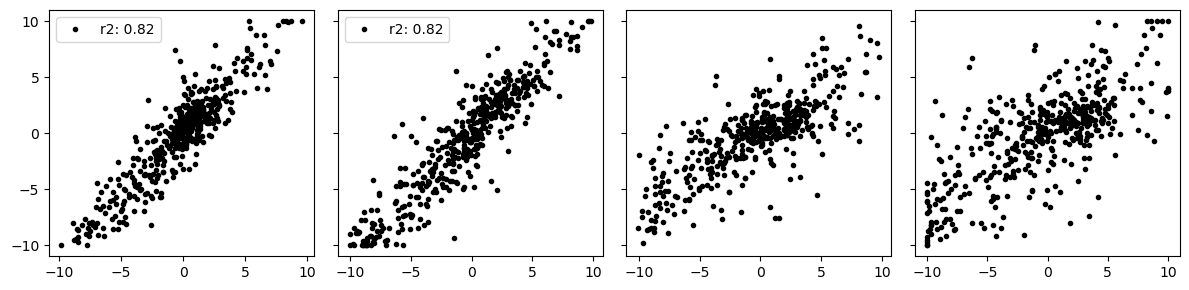

In [49]:

f,axes = plt.subplots(1,4, figsize=(12,3), sharey=True)
axes.flat[0].plot(yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.', label=f'r2: {r2_score(y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel()):.2f}')
axes.flat[1].plot(yhat_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.', label=f'r2: {r2_score(y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel()):.2f}')
axes.flat[2].plot(yhat_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), yhat_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.')
axes.flat[3].plot(y_toexplain[:, data.output_node_mask].detach().cpu().numpy().ravel(), y_baseline[:, data.output_node_mask].detach().cpu().numpy().ravel(), 'k.')
axes.flat[0].legend()
axes.flat[1].legend()
plt.tight_layout()
plt.show()

In [64]:
explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=2000, lr=1e-2, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=500)

res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=x_baseline, x=x_toexplain, return_predictions=True)

WARNING! r2(yhat_x, yhat_baseline) > 0 - this indicates the model predicts similar outcomes for x and baseline. This may indicate poor observation prediction.
iter: 1999 | mse: 3.00449848 | r2: 0.615 | active edges: 1428.0
Final r2 (MLE): 0.6155026255280359


In [65]:
res[lambda x: (x.source == 'PROTEIN__P03372')].sort_values('score', ascending=False).head(10)

source             target     score
78    PROTEIN__P03372        RNA__P07339  0.999960
482   PROTEIN__P03372        RNA__Q9UHN6  0.999959
6540  PROTEIN__P03372  RNA__MIMAT0004568  0.999956
69    PROTEIN__P03372        RNA__P31749  0.999937
6515  PROTEIN__P03372  RNA__MIMAT0000437  0.999916
6528  PROTEIN__P03372  RNA__MIMAT0000073  0.999905
492   PROTEIN__P03372        RNA__P18084  0.999904
507   PROTEIN__P03372        RNA__P47736  0.999848
6512  PROTEIN__P03372  RNA__MIMAT0004599  0.999843
517   PROTEIN__P03372        RNA__Q9ULJ6  0.999811

In [66]:
res[lambda x: (x.target == 'RNA__Q8WYB5')].sort_values('score', ascending=False).head(5)

source       target     score
17504      RNA__Q8WYB5  RNA__Q8WYB5  0.999760
493    PROTEIN__P03372  RNA__Q8WYB5  0.999702
12835     EXPR__Q8WYB5  RNA__Q8WYB5  0.999021
14742      CNV__Q8WYB5  RNA__Q8WYB5  0.996146
13819   METHYL__Q8WYB5  RNA__Q8WYB5  0.000753

In [67]:
res[lambda x: (x.source == 'RNA__Q8WYB5')].sort_values('score', ascending=False).head(5)

source         target    score
11979  RNA__Q8WYB5  LINCS__Q8WYB5  0.99997
17504  RNA__Q8WYB5    RNA__Q8WYB5  0.99976

In [68]:
lincs_idx = np.where(data.node_names == 'LINCS__O60238')[0]
lincs_idx

array([2119])

In [69]:
y_baseline.shape

torch.Size([1, 5369, 1])

In [70]:
print('y PC3', y_baseline.squeeze()[[lincs_idx]]) 
print('y A375', y_toexplain.squeeze()[[lincs_idx]]) 
print('yhat PC3', yhat_baseline.squeeze()[[lincs_idx]]) 
print('yhat A375', yhat_toexplain.squeeze()[[lincs_idx]]) 

y PC3 tensor([-4.6964])
y A375 tensor([0.6546])
yhat PC3 tensor([-3.8842])
yhat A375 tensor([3.2761])


full graph size: 836
largest comp. subgraph 753


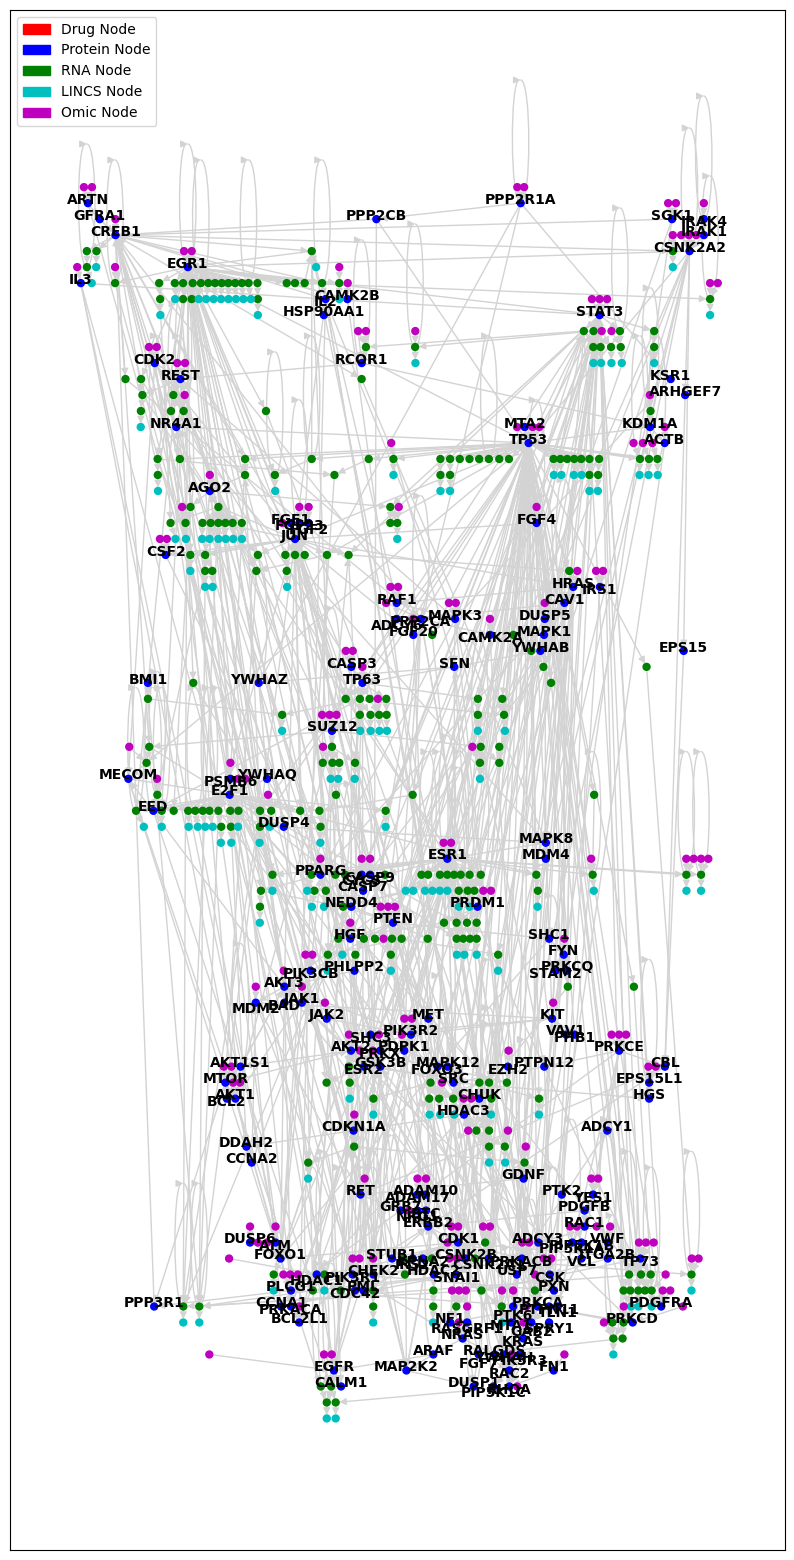

In [71]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10)

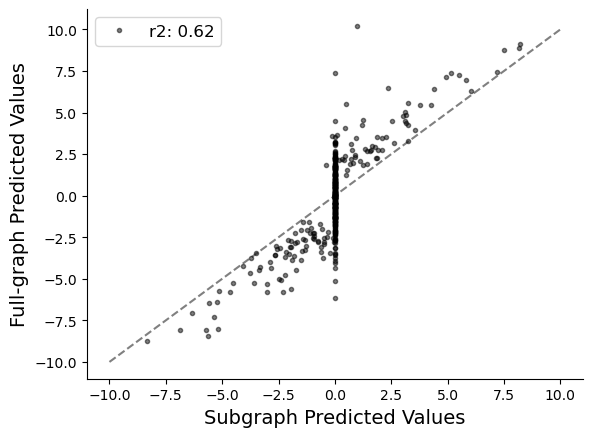

In [72]:
ax = plt.subplot(111)
ax.plot((-10, 10), (-10, 10), c='gray', linestyle='--') 
ax.plot(subgraph_preds, full_graph_preds, 'k.', label=f'r2: {r2:.2f}', alpha=0.5) 
ax.set_xlabel('Subgraph Predicted Values', fontsize=14)
ax.set_ylabel('Full-graph Predicted Values', fontsize=14)
plt.legend(fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [100]:
# idx=2000 # 20uM, PC3, BRD-K50691590
# idx=33373 # 20uM, MCF7, BRD-K50691590

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=1000, lr=1e-2, weight_decay=1e-6, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam)

xx = X[[2000]]
xx0 = X[[33373]]

res, r2 = explainer.explain(baseline=xx0, x=xx)

iter: 999 | mse: 2.47934103 | r2: 0.736 | active edges: 1301.00
Final r2 (MLE): 0.7539806684700244


In [101]:
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

In [102]:
res = res.assign(source_symb = [uni2symb[x.split('__')[1]] if x.split('__')[1] in uni2symb else None for x in res.source.values])
res = res.assign(target_symb = [uni2symb[x.split('__')[1]] if x.split('__')[1] in uni2symb else None for x in res.target.values])
res.head()

source       target     score source_symb target_symb
0  PROTEIN__P04637  RNA__P08069  0.001888        TP53       IGF1R
1  PROTEIN__P40763  RNA__P38936  0.001977       STAT3      CDKN1A
2  PROTEIN__P04637  RNA__P38936  0.003031        TP53      CDKN1A
3  PROTEIN__P04637  RNA__P06400  0.001853        TP53         RB1
4  PROTEIN__Q01094  RNA__P38936  0.002333        E2F1      CDKN1A

In [103]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('EXPR')].head(5)

source           target     score source_symb target_symb
13403  EXPR__P15056  PROTEIN__P15056  0.999895        BRAF        BRAF
13386  EXPR__P08581  PROTEIN__P08581  0.999870         MET         MET
13464  EXPR__P32121  PROTEIN__P32121  0.999847       ARRB2       ARRB2
13356  EXPR__O96017  PROTEIN__O96017  0.999837       CHEK2       CHEK2
13603  EXPR__Q14186  PROTEIN__Q14186  0.999813       TFDP1       TFDP1

In [104]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('MUT')].head(5)

source           target     score source_symb target_symb
15772  MUT__P15407      RNA__P15407  0.999476       FOSL1       FOSL1
16364  MUT__P42336  PROTEIN__P42336  0.999360      PIK3CA      PIK3CA
16133  MUT__Q9HD45      RNA__Q9HD45  0.998587      TM9SF3      TM9SF3
16530  MUT__Q92529  PROTEIN__Q92529  0.998488        SHC3        SHC3
16368  MUT__P42574  PROTEIN__P42574  0.998222       CASP3       CASP3

In [105]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('METHYL')].head(5)

source           target     score source_symb target_symb
14348  METHYL__P12931  PROTEIN__P12931  0.999796         SRC         SRC
14297  METHYL__O75626  PROTEIN__O75626  0.999768       PRDM1       PRDM1
14485  METHYL__Q02750  PROTEIN__Q02750  0.999743      MAP2K1      MAP2K1
14322  METHYL__P04049  PROTEIN__P04049  0.999711        RAF1        RAF1
14362  METHYL__P18146  PROTEIN__P18146  0.999642        EGR1        EGR1

In [106]:
res.sort_values(by='score', ascending=False)[lambda x: x.source.str.contains('CNV')].head(5)

source           target     score source_symb target_symb
15256  CNV__P01589  PROTEIN__P01589  0.999889       IL2RA       IL2RA
15480  CNV__Q14186  PROTEIN__Q14186  0.999871       TFDP1       TFDP1
15290  CNV__P10721  PROTEIN__P10721  0.999853         KIT         KIT
15271  CNV__P05412  PROTEIN__P05412  0.999848         JUN         JUN
15283  CNV__P09619  PROTEIN__P09619  0.999835      PDGFRB      PDGFRB

In [111]:
res.sort_values(by='score', ascending=False)[lambda x: x.target_symb == 'TP53'].head(25)

source           target     score source_symb target_symb
1937     PROTEIN__P27361  PROTEIN__P04637  0.999881       MAPK3        TP53
12042        RNA__P04637    LINCS__P04637  0.999869        TP53        TP53
3723     PROTEIN__O15151  PROTEIN__P04637  0.999862        MDM4        TP53
4429     PROTEIN__Q05655  PROTEIN__P04637  0.999849       PRKCD        TP53
685      PROTEIN__Q9H3D4  PROTEIN__P04637  0.999847        TP63        TP53
13373       EXPR__P04637  PROTEIN__P04637  0.999806        TP53        TP53
4768     PROTEIN__Q8N726  PROTEIN__P04637  0.999761      CDKN2A        TP53
1848     PROTEIN__P35232  PROTEIN__P04637  0.999750        PHB1        TP53
10772  RNA__MIMAT0002875      RNA__P04637  0.999741        None        TP53
8545   RNA__MIMAT0004556      RNA__P04637  0.999607        None        TP53
1865     PROTEIN__P45983  PROTEIN__P04637  0.999521       MAPK8        TP53
12785       EXPR__P04637      RNA__P04637  0.999369        TP53        TP53
803      PROTEIN__O60341  PROTEIN__P04637  0.999348       KDM1A        TP53
4369     PROTEIN__P45983  PROTEIN__P04637  0.999094       MAPK8        TP53
8819   RNA__MIMAT0004657      RNA__P04637  0.999043        None        TP53
2179     PROTEIN__Q13362  PROTEIN__P04637  0.999019     PPP2R5C        TP53
8665   RNA__MIMAT0004697      RNA__P04637  0.998457        None        TP53
3804     PROTEIN__Q13315  PROTEIN__P04637  0.998440         ATM        TP53
3596     PROTEIN__O15350  PROTEIN__P04637  0.998435        TP73        TP53
2016     PROTEIN__Q05655  PROTEIN__P04637  0.998241       PRKCD        TP53
4677     PROTEIN__P28482  PROTEIN__P04637  0.997518       MAPK1        TP53
15266        CNV__P04637  PROTEIN__P04637  0.997165        TP53        TP53
3083     PROTEIN__Q07817  PROTEIN__P04637  0.996802      BCL2L1        TP53
6733     PROTEIN__P05412  PROTEIN__P04637  0.996097         JUN        TP53
824      PROTEIN__O15151  PROTEIN__P04637  0.990801        MDM4        TP53

In [114]:
print('baseline TP53 CNV', xx0[:, data.node_names.tolist().index('CNV__P04637'), :])
print('obs TP53 CNV', xx[:, data.node_names.tolist().index('CNV__P04637'), :])

baseline TP53 CNV tensor([[0.3507]])
obs TP53 CNV tensor([[-0.8768]])


In [115]:
print('baseline TP53 EXPR', xx0[:, data.node_names.tolist().index('EXPR__P04637'), :])
print('obs TP53 EXPR', xx[:, data.node_names.tolist().index('EXPR__P04637'), :])

baseline TP53 EXPR tensor([[0.9611]])
obs TP53 EXPR tensor([[-2.4842]])


full graph size: 712
largest comp. subgraph 692


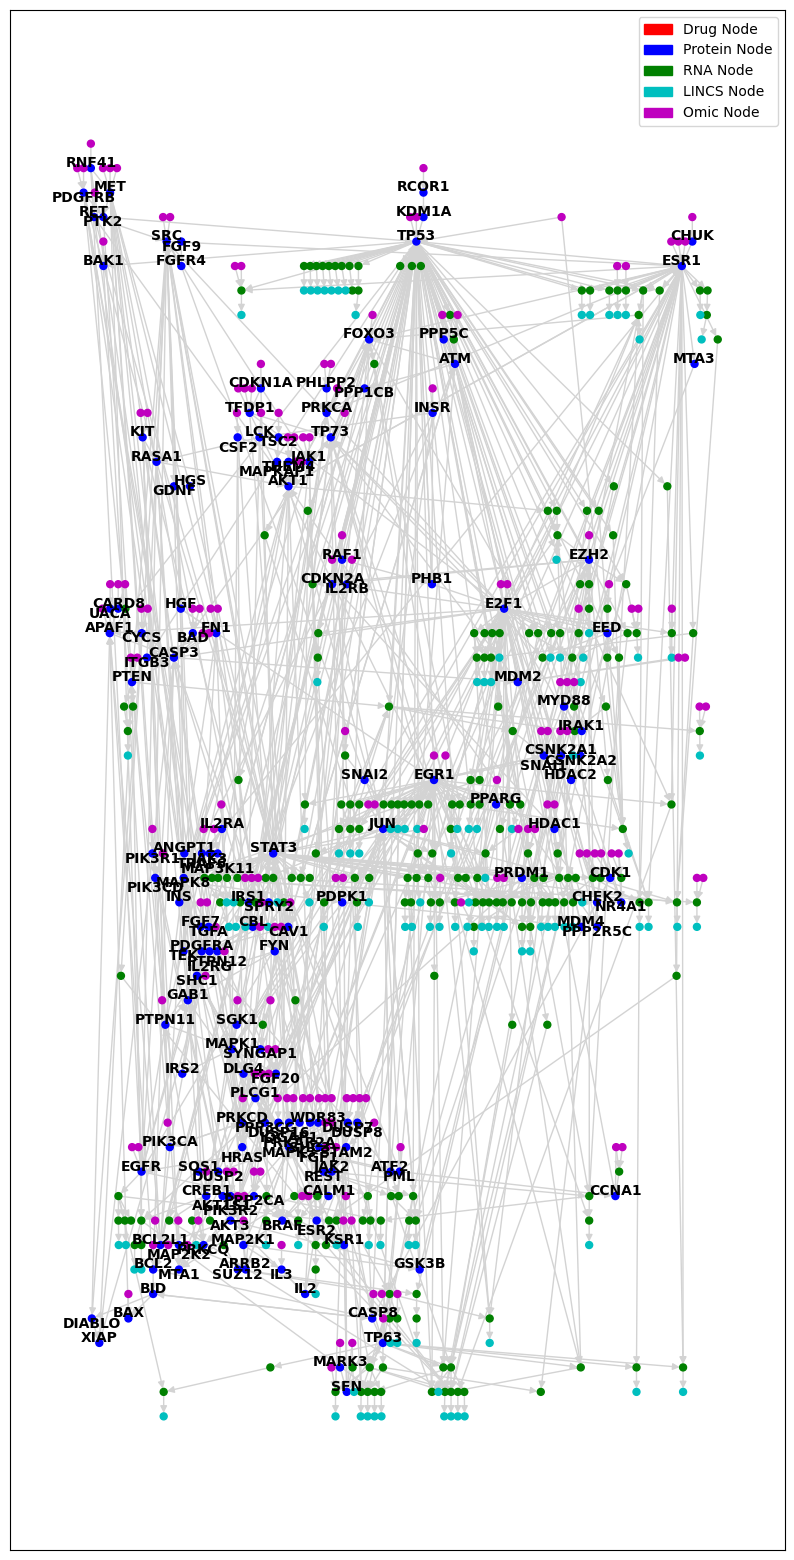

In [108]:
plot_explanation_graph(res, figsize=(10, 20), fontsize=10)

In [235]:
explainer = GSNNExplainer(model, data, gumbel_softmax=True, hard=False, prior=1, normalize_target=True)
NERATINIB_mcf7 = explainer.explain(X[[mcf7idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=1e-3, iters=2000, lr=1e-2, desired_edges=750.)

z-scoring target || (target dist params) mean, std: (tensor(-0.0049, device='cuda:0'), tensor(0.2926, device='cuda:0'))


KeyboardInterrupt: 

In [213]:
NERATINIB_mcf7[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(25)

source           target     score
11158  DRUG__BRD-K85606544  PROTEIN__P04626  0.947283
11157  DRUG__BRD-K85606544  PROTEIN__P00533  0.944301

In [214]:
explainer = GSNNExplainer(model, data, gumbel_softmax=True, hard=False, prior=1, normalize_target=True)
NERATINIB_skbr3 = explainer.explain(X[[skbr3idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=1e-3, iters=2000, lr=1e-2, desired_edges=750.)

z-scoring target || (target dist params) mean, std: (tensor(-0.0043, device='cuda:0'), tensor(0.2681, device='cuda:0'))


In [215]:
# HER2 -- PROTEIN__P04626
# lapatinib : BRD-K19687926
# neratinib : DRUG__BRD-K85606544
NERATINIB_skbr3.set_index('source').loc['DRUG__BRD-K85606544']

target     score
source                                        
DRUG__BRD-K85606544  PROTEIN__P00533  0.929886
DRUG__BRD-K85606544  PROTEIN__P04626  0.957670

In [216]:
NERATINIB_skbr3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(50)

source           target     score
11158  DRUG__BRD-K85606544  PROTEIN__P04626  0.957670
11157  DRUG__BRD-K85606544  PROTEIN__P00533  0.929886

In [217]:
nerdf = NERATINIB_bt20.rename({'score':'bt20_score'}, axis=1).merge(NERATINIB_mcf7.rename({'score':'mcf7_score'}, axis=1), on=['source', 'target']).merge(NERATINIB_skbr3.rename({'score':'skbr3_score'}, axis=1), on=['source', 'target'])
nerdf.head()

source       target  bt20_score  mcf7_score  skbr3_score
0  PROTEIN__P01106  RNA__O14746    0.000339    0.003550     0.002274
1  PROTEIN__P42224  RNA__P38936    0.000801    0.000231     0.001203
2  PROTEIN__P40763  RNA__P38936    0.001210    0.000801     0.029069
3  PROTEIN__P42229  RNA__P05019    0.000424    0.000291     0.000189
4  PROTEIN__P42229  RNA__P24385    0.000511    0.000286     0.000380

In [218]:
nerdf[['bt20_score', 'mcf7_score', 'skbr3_score']].corr()

bt20_score  mcf7_score  skbr3_score
bt20_score     1.000000    0.462603     0.475744
mcf7_score     0.462603    1.000000     0.534117
skbr3_score    0.475744    0.534117     1.000000

In [219]:
nerdf2 = nerdf.assign(bt20=lambda x: x.bt20_score > 0.5,
                      mcf7=lambda x: x.mcf7_score > 0.5,
                      skbr3=lambda x: x.skbr3_score > 0.5)
nerdf2 = nerdf2.assign(at_least_one = lambda x: x.bt20 | x.mcf7 | x.skbr3)
nerdf2 = nerdf2.assign(all_three = lambda x: x.bt20 & x.mcf7 & x.skbr3)
nerdf2 = nerdf2[lambda x: x.at_least_one]

nodespace = np.unique(nerdf2.source.tolist() + nerdf2.target.tolist())

print('# nodes:', len(nodespace))
print('# edges:', len(nerdf2))
nerdf2.head()                      

# nodes: 1884
# edges: 4100


source       target  bt20_score  mcf7_score  skbr3_score  bt20  \
12  PROTEIN__P11831  RNA__P01100    0.544866    0.000429     0.001510  True   
16  PROTEIN__P11831  RNA__P18146    0.962130    0.388942     0.026013  True   
18  PROTEIN__P01106  RNA__P04637    0.980102    0.001975     0.000482  True   
21  PROTEIN__P16220  RNA__P18146    0.999469    0.471424     0.682308  True   
27  PROTEIN__P16220  RNA__P05412    0.985972    0.849327     0.994503  True   

     mcf7  skbr3  at_least_one  all_three  
12  False  False          True      False  
16  False  False          True      False  
18  False  False          True      False  
21  False   True          True      False  
27   True   True          True       True

In [220]:
# how many edges are considered important by all three cell lines 
nerdf2.all_three.sum()

623

In [221]:
# total # of shared cell lines 
nerdf2.shape[0]

4100

In [222]:
G = nx.from_pandas_edgelist(nerdf2, create_using=nx.DiGraph, edge_attr=['bt20', 'mcf7', 'skbr3'])
len(G)

1884

In [223]:
nx.is_connected(G.to_undirected())

False

In [224]:
len(list(nx.isolates(G.to_undirected())))

0

In [225]:
for i,comp in enumerate(nx.connected_components(G.to_undirected())): 
    print(i, len(comp))
    if i > 3: break

0 1337
1 5
2 9
3 6
4 5


In [226]:
# select only the largest connected component 
G = G.subgraph(next(iter(nx.connected_components(G.to_undirected()))))

Creating legend with loc="best" can be slow with large amounts of data.


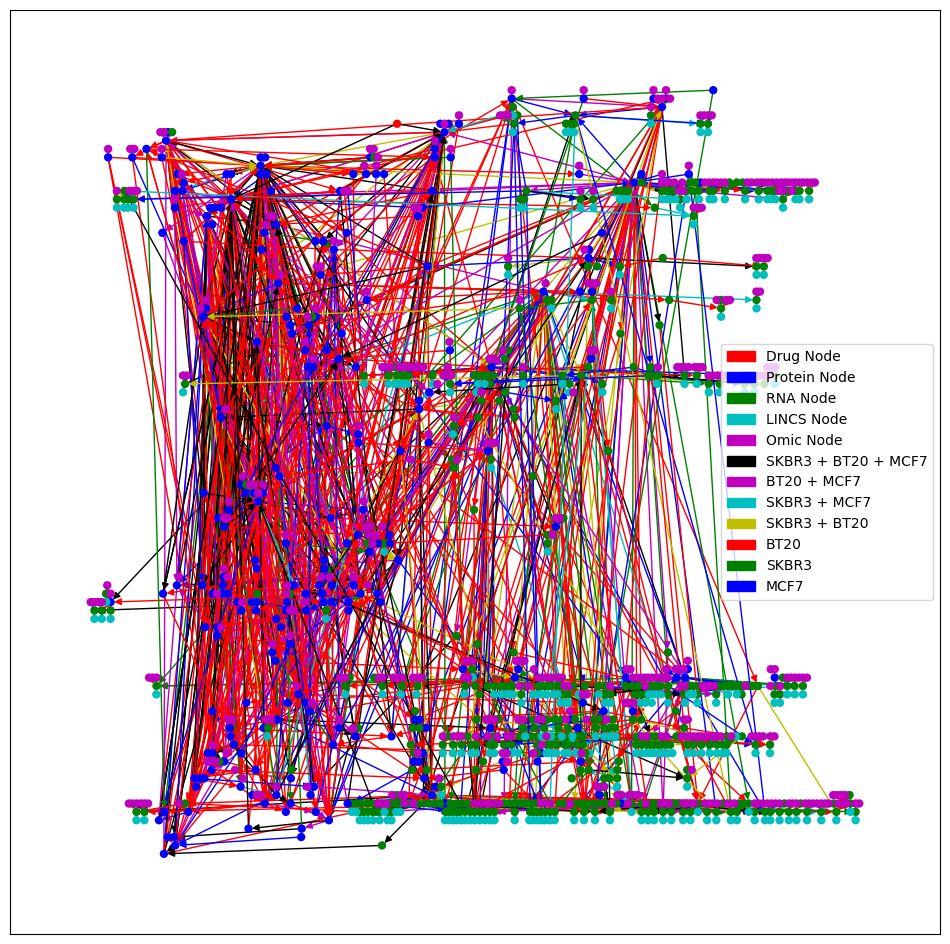

In [227]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

node_colors = [] 

_DRUGCOLOR = 'r'
_PROTEINCOLOR = 'b'
_RNACOLOR = 'g'
_LINCSCOLOR = 'c'
_OMICSCOLOR = 'm'

for node in G.nodes(): 

    type_ = node.split('__')[0]
    if type_ == 'DRUG': 
        node_colors.append(_DRUGCOLOR)
    elif type_ == 'PROTEIN': 
        node_colors.append(_PROTEINCOLOR)
    elif type_ == 'RNA': 
        node_colors.append(_RNACOLOR)
    elif type_ == 'LINCS': 
        node_colors.append(_LINCSCOLOR)
    else: 
        # omic node
        node_colors.append(_OMICSCOLOR)

edge_colors = []

_ALLLINES = 'k'
_BT_MC = 'm' # r + b  ~ purple 
_MC_SK = 'c' # b + g ~ cyan 
_BT_SK = 'y' # r + g ~ yellow
_BT = 'r'
_SK = 'g'
_MC = 'b'


for edge in G.edges():
    if G.edges[edge]['bt20'] & G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_ALLLINES)
    elif G.edges[edge]['bt20'] & G.edges[edge]['mcf7']: 
        edge_colors.append(_BT_MC)
    elif G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_MC_SK)
    elif G.edges[edge]['bt20'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_BT_SK)
    elif G.edges[edge]['bt20']: 
        edge_colors.append(_BT)
    elif G.edges[edge]['mcf7']: 
        edge_colors.append(_MC)
    elif G.edges[edge]['skbr3']: 
        edge_colors.append(_SK)
    else: 
        edge_colors.append(_INACTIVEEDGE)

plt.figure(figsize=(12,12))

drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
_rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

allmp = mpatches.Patch(color=_ALLLINES, label='SKBR3 + BT20 + MCF7')
btmcmp = mpatches.Patch(color=_BT_MC, label='BT20 + MCF7')
mcskmp = mpatches.Patch(color=_MC_SK, label='SKBR3 + MCF7')
btskmp = mpatches.Patch(color=_BT_SK, label='SKBR3 + BT20')
btmp = mpatches.Patch(color=_BT, label='BT20')
skmp = mpatches.Patch(color=_SK, label='SKBR3')
mcmp = mpatches.Patch(color=_MC, label='MCF7')

nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, allmp, btmcmp, mcskmp, btskmp, btmp, skmp, mcmp])

#plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
plt.show()

In [228]:
tfs = [] 
for i,row in nerdf2.iterrows(): 
    if (row.source.split('__')[0] == 'PROTEIN') & (row.target.split('__')[0] == 'RNA'): 
        tfs.append(row.source)

tfs = np.unique(tfs)
len(tfs)


38

In [229]:
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

bt20


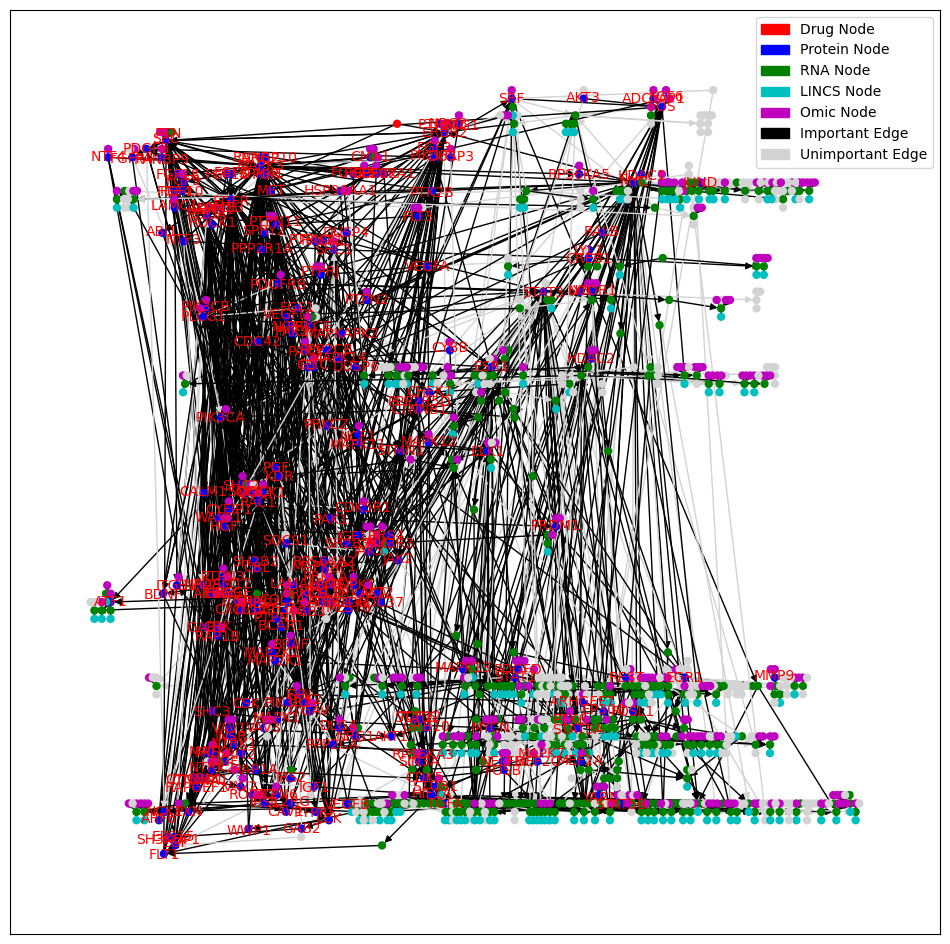

mcf7


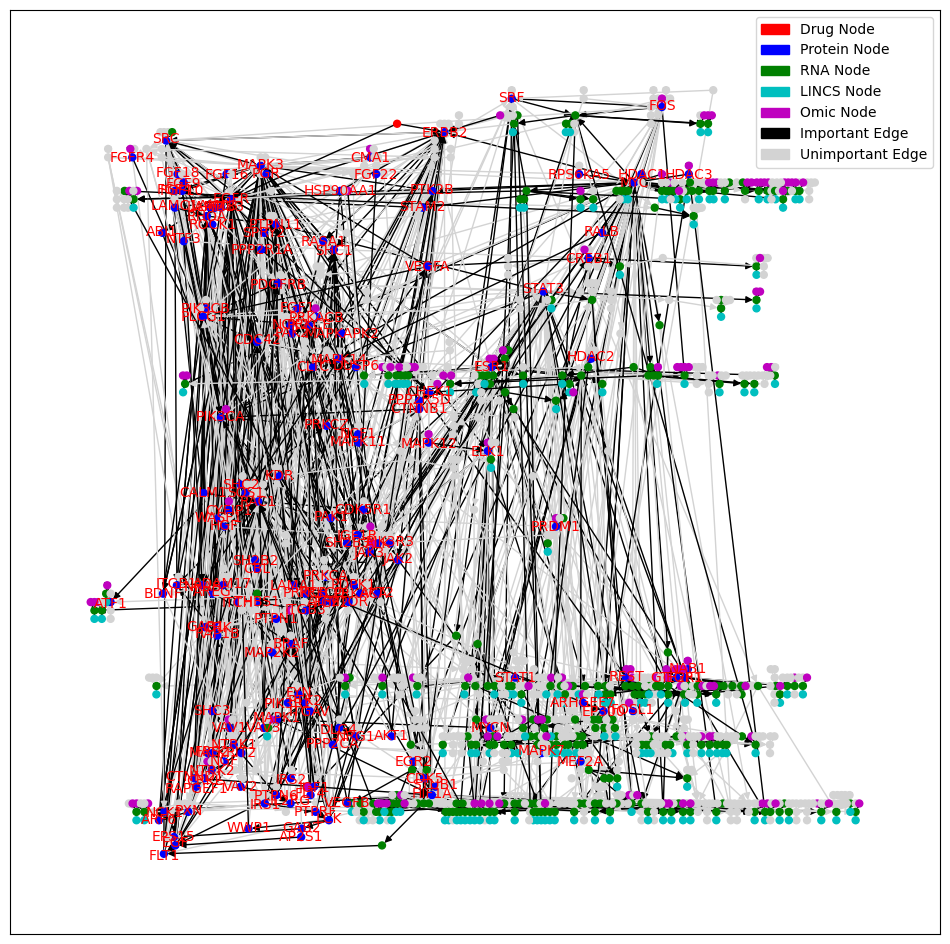

skbr3


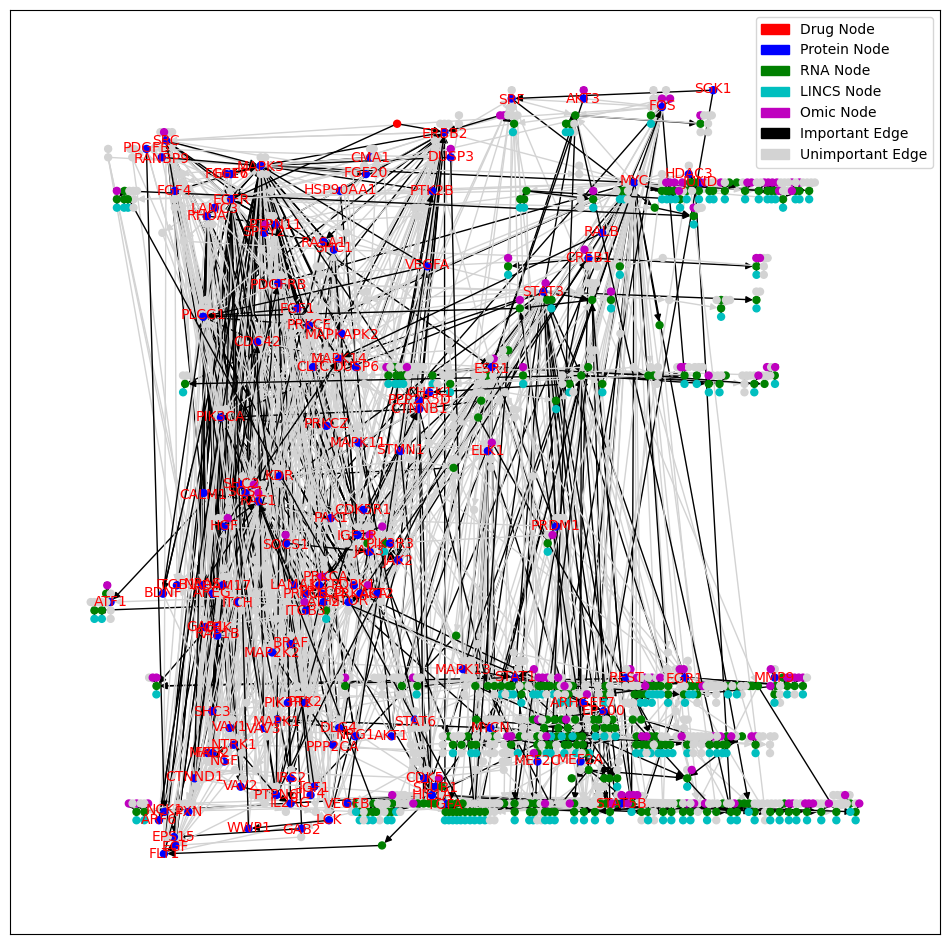

In [230]:
#NOTE: plots each cell line graph individually. 


pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

for attr in ['bt20', 'mcf7', 'skbr3']: 
    print(attr)

    node_colors = [] 

    _DRUGCOLOR = 'r'
    _PROTEINCOLOR = 'b'
    _RNACOLOR = 'g'
    _LINCSCOLOR = 'c'
    _OMICSCOLOR = 'm'

    node_label_dict = {}

    for node in G.nodes(): 
        
        has_active_edge = False
        for edge in G.edges(node): 
            if G.edges[edge][attr]: 
                has_active_edge = True 
                break 
        for parent in G.predecessors(node): 
            if G.edges[(parent, node)][attr]: 
                has_active_edge = True 
                break 

        if not has_active_edge: 
            node_colors.append('lightgray')
        else: 

            type_ = node.split('__')[0]
            if type_ == 'DRUG': 
                node_colors.append(_DRUGCOLOR)
            elif type_ == 'PROTEIN': 
                node_label_dict[node] = uni2symb[node.split('__')[-1]]
                node_colors.append(_PROTEINCOLOR)
            elif type_ == 'RNA': 
                node_colors.append(_RNACOLOR)
            elif type_ == 'LINCS': 
                node_colors.append(_LINCSCOLOR)
            else: 
                # omic node
                node_colors.append(_OMICSCOLOR)

    edge_colors = []

    _ACTIVEEDGE = 'k'
    _INACTIVEEDGE = 'lightgray'

    for edge in G.edges():
        if G.edges[edge][attr]: 
            edge_colors.append(_ACTIVEEDGE)
        else: 
            edge_colors.append(_INACTIVEEDGE)

    plt.figure(figsize=(12,12))

    drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
    prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
    _rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
    linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
    omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

    active_patch = mpatches.Patch(color=_ACTIVEEDGE, label='Important Edge')
    inactive_patch = mpatches.Patch(color=_INACTIVEEDGE, label='Unimportant Edge')

    nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos={k:(x, y+10*np.random.randn(1).item()) for k, (x,y) in pos.items()}, font_size=10, labels=node_label_dict, font_color='r', font_weight='normal')
    nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
    plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, active_patch, inactive_patch])
    
    #plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    #plt.savefig(f'../extdata/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    plt.show()

In [167]:
# load ppi context 
ppicontext = pd.read_csv('../../data/ppi_context_v_1_00.txt', sep='\t')
ppicontext.head()

id   gene_a   gene_b       pid cell_name  \
0   0  ALDH1A1  ALDH1A1  25416956       HEK   
1   2  PPP1R9A    ACTG1   9362513      Rat1   
2   2  PPP1R9A    ACTG1   9362513      PC12   
3   2  PPP1R9A    ACTG1   9362513       Sf9   
4   2  PPP1R9A    ACTG1   9362513     COS-7   

                          cell_category cell_sex           cell_species  
0                      Cancer cell line   Female           Homo sapiens  
1  Spontaneously immortalized cell line      NaN      Rattus norvegicus  
2                      Cancer cell line     Male      Rattus norvegicus  
3  Spontaneously immortalized cell line   Female  Spodoptera frugiperda  
4                 Transformed cell line     Male   Chlorocebus aethiops

In [168]:
[x for x in np.sort(ppicontext.cell_name.unique()).tolist() if 'SK' in x]

['IGSK-1',
 'SK 7',
 'SK-BR-3',
 'SK-BR-7',
 'SK-CO-1',
 'SK-GT-4',
 'SK-HEP-1',
 'SK-LMS-1',
 'SK-LU-1',
 'SK-MEL-1',
 'SK-MEL-10',
 'SK-MEL-100',
 'SK-MEL-103',
 'SK-MEL-108',
 'SK-MEL-14',
 'SK-MEL-147',
 'SK-MEL-2',
 'SK-MEL-239',
 'SK-MEL-24',
 'SK-MEL-28',
 'SK-MEL-31',
 'SK-MEL-37',
 'SK-MEL-5',
 'SK-MES-1',
 'SK-MG-13',
 'SK-MG-7',
 'SK-MM-1',
 'SK-N-AS',
 'SK-N-BE(2)',
 'SK-N-BE(2)-C',
 'SK-N-DZ',
 'SK-N-MC',
 'SK-N-SH',
 'SK-NEP-1',
 'SK-OV-3',
 'SK-PC-1',
 'SK-RC-10',
 'SK-RC-47',
 'SK-UT-1',
 'SKI-DLCL-1',
 'SKNO-1',
 'SKOV3.ip1',
 'SKW 6.4']

In [169]:
nerdf3 = nerdf2 # nerdf2[lambda x: x.source.str.contains('PROTEIN__') & x.target.str.contains('PROTEIN__')][lambda x: x.source.isin(G.nodes()) & x.target.isin(G.nodes())]
print(nerdf3.shape)
nerdf3 = nerdf3.assign(gene_a = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.source.values])
nerdf3 = nerdf3.assign(gene_b = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.target.values])
nerdf3.head()

(591, 10)


source       target  bt20_score  mcf7_score  skbr3_score   bt20  \
10   PROTEIN__P01106  RNA__P30304    0.031532    0.060274     0.650784  False   
13   PROTEIN__P01106  RNA__P38936    0.023346    0.005095     0.910074  False   
20   PROTEIN__P01106  RNA__P38398    0.005836    0.004118     0.925757  False   
84   PROTEIN__P03372  RNA__P38936    0.021645    0.030348     0.797121  False   
112  PROTEIN__P18146  RNA__P37231    0.012270    0.003229     0.972849  False   

      mcf7  skbr3  at_least_one  all_three gene_a  gene_b  
10   False   True          True      False    MYC  CDC25A  
13   False   True          True      False    MYC  CDKN1A  
20   False   True          True      False    MYC   BRCA1  
84   False   True          True      False   ESR1  CDKN1A  
112  False   True          True      False   EGR1   PPARG

In [170]:
# ppi context, subset to the 3 cell line world. e.g., only include a ppi context if it appears in at least one of the three cell lines 
ppicontext2 = ppicontext.merge(nerdf3[['gene_a', 'gene_b']], on=['gene_a', 'gene_b'], how='inner')[['gene_a', 'gene_b', 'cell_name']].drop_duplicates()

In [171]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
bt20_res_ = nerdf3_bt20.merge(ppicontext2[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='right')

FP = bt20_res_.IMPORTANT_EDGE.isna().sum()
TP = bt20_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

0 0
nan nan


invalid value encountered in long_scalars


In [172]:
nerdf3_mcf7 = nerdf3[lambda x: x.mcf7][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True).drop_duplicates()

# number of important MCF7 edges that were also reported in PPI context 
mcf7_res_ = nerdf3_mcf7.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

FP = mcf7_res_.IMPORTANT_EDGE.isna().sum()
TP = mcf7_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

null_fdr = []
for i in range(1000): 

    rand_mask = np.random.permutation(nerdf3.mcf7.values)
    #rand_mask = np.random.randn(nerdf3.mcf7.values.shape[0]) > 0

    nerdf3_rand = nerdf3[rand_mask][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

    # number of important MCF7 edges that were also reported in PPI context 
    rand_res_ = nerdf3_rand.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

    FP_ = rand_res_.IMPORTANT_EDGE.isna().sum()
    TP_ = rand_res_.IMPORTANT_EDGE.sum() 
    PPV_ = TP_ / (TP_ + FP_)
    FDR_ = 1 - PPV_

    null_fdr.append(FDR_)

# probability of being attained by random
1-(FDR < null_fdr).mean()

null_fdr


1 9
0.1 0.9


[0.2142857142857143,
 0.16666666666666663,
 0.25,
 0.25,
 0.4,
 0.16666666666666663,
 0.5,
 0.4545454545454546,
 0.3076923076923077,
 0.1428571428571429,
 0.5,
 0.33333333333333337,
 0.3846153846153846,
 0.15384615384615385,
 0.09999999999999998,
 0.25,
 0.33333333333333337,
 0.08333333333333337,
 0.33333333333333337,
 0.36363636363636365,
 0.4545454545454546,
 0.33333333333333337,
 0.4545454545454546,
 0.25,
 0.3076923076923077,
 0.3076923076923077,
 0.33333333333333337,
 0.4545454545454546,
 0.18181818181818177,
 0.1428571428571429,
 0.0714285714285714,
 0.09090909090909094,
 0.23076923076923073,
 0.15384615384615385,
 0.15384615384615385,
 0.16666666666666663,
 0.18181818181818177,
 0.3076923076923077,
 0.25,
 0.15384615384615385,
 0.36363636363636365,
 0.46153846153846156,
 0.4545454545454546,
 0.3846153846153846,
 0.33333333333333337,
 0.23076923076923073,
 0.25,
 0.09999999999999998,
 0.16666666666666663,
 0.46153846153846156,
 0.18181818181818177,
 0.3076923076923077,
 0.2727272

In [173]:
for i,row in mcf7_res_.assign(GSNN_EDGE = lambda x: x.IMPORTANT_EDGE == True).iterrows(): 
    print(f'{row.gene_a} & {row.gene_b} & {row.GSNN_EDGE}', end=' \\\\ \\hline\n')

BRCA1 & BRCA1 & False \\ \hline
BNIP3 & BNIP3 & False \\ \hline
CDKN2A & CDKN2A & False \\ \hline
EGFR & EGFR & False \\ \hline
ESR1 & ESR1 & True \\ \hline
APP & APP & False \\ \hline
MYC & MYC & False \\ \hline
MUC1 & MUC1 & False \\ \hline
STUB1 & STUB1 & False \\ \hline
CDK4 & CDK4 & False \\ \hline


In [174]:
nerdf3_skbr3 = nerdf3[lambda x: x.skbr3][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
skbr3_res_ = nerdf3_skbr3.merge(ppicontext2[lambda x: x.cell_name == 'SK-BR-3'], on=['gene_a', 'gene_b'], how='right')

FP = skbr3_res_.IMPORTANT_EDGE.isna().sum()
TP = skbr3_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)



0 2
0.0 1.0


In [175]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20]
nerdf3_bt20.merge(ppicontext[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='inner')

Empty DataFrame
Columns: [source, target, bt20_score, mcf7_score, skbr3_score, bt20, mcf7, skbr3, at_least_one, all_three, gene_a, gene_b, id, pid, cell_name, cell_category, cell_sex, cell_species]
Index: []

In [176]:
set(list(pos.keys())).difference(set(list(G.nodes())))

set()

In [177]:
set(list(pos.keys()))

{'CNV__O15392',
 'CNV__P00533',
 'CNV__P01111',
 'CNV__P05556',
 'CNV__P15407',
 'CNV__P16035',
 'CNV__Q14289',
 'EXPR__P01106',
 'EXPR__P03372',
 'EXPR__P05556',
 'EXPR__P15407',
 'EXPR__P30304',
 'EXPR__Q07889',
 'EXPR__Q9NQC1',
 'LINCS__O00762',
 'LINCS__O14757',
 'LINCS__O15392',
 'LINCS__P00533',
 'LINCS__P05067',
 'LINCS__P06241',
 'LINCS__P06493',
 'LINCS__P11802',
 'LINCS__P12004',
 'LINCS__P15407',
 'LINCS__P16035',
 'LINCS__P16949',
 'LINCS__P20248',
 'LINCS__P30281',
 'LINCS__P30304',
 'LINCS__P38398',
 'LINCS__P38936',
 'LINCS__P53350',
 'LINCS__Q04724',
 'LINCS__Q08257',
 'LINCS__Q13794',
 'LINCS__Q9UNS1',
 'METHYL__P01100',
 'METHYL__P03372',
 'METHYL__P09038',
 'METHYL__P30304',
 'PROTEIN__O15379',
 'PROTEIN__O15530',
 'PROTEIN__O43597',
 'PROTEIN__O76093',
 'PROTEIN__P00533',
 'PROTEIN__P01100',
 'PROTEIN__P01106',
 'PROTEIN__P01111',
 'PROTEIN__P01112',
 'PROTEIN__P03372',
 'PROTEIN__P04198',
 'PROTEIN__P05106',
 'PROTEIN__P05556',
 'PROTEIN__P06239',
 'PROTEIN__P06241

In [178]:
set(list(G.nodes()))

{'CNV__O15392',
 'CNV__P00533',
 'CNV__P01111',
 'CNV__P05556',
 'CNV__P15407',
 'CNV__P16035',
 'CNV__Q14289',
 'EXPR__P01106',
 'EXPR__P03372',
 'EXPR__P05556',
 'EXPR__P15407',
 'EXPR__P30304',
 'EXPR__Q07889',
 'EXPR__Q9NQC1',
 'LINCS__O00762',
 'LINCS__O14757',
 'LINCS__O15392',
 'LINCS__P00533',
 'LINCS__P05067',
 'LINCS__P06241',
 'LINCS__P06493',
 'LINCS__P11802',
 'LINCS__P12004',
 'LINCS__P15407',
 'LINCS__P16035',
 'LINCS__P16949',
 'LINCS__P20248',
 'LINCS__P30281',
 'LINCS__P30304',
 'LINCS__P38398',
 'LINCS__P38936',
 'LINCS__P53350',
 'LINCS__Q04724',
 'LINCS__Q08257',
 'LINCS__Q13794',
 'LINCS__Q9UNS1',
 'METHYL__P01100',
 'METHYL__P03372',
 'METHYL__P09038',
 'METHYL__P30304',
 'PROTEIN__O15379',
 'PROTEIN__O15530',
 'PROTEIN__O43597',
 'PROTEIN__O76093',
 'PROTEIN__P00533',
 'PROTEIN__P01100',
 'PROTEIN__P01106',
 'PROTEIN__P01111',
 'PROTEIN__P01112',
 'PROTEIN__P03372',
 'PROTEIN__P04198',
 'PROTEIN__P05106',
 'PROTEIN__P05556',
 'PROTEIN__P06239',
 'PROTEIN__P06241

KeyError: 'PROTEIN__P01100'

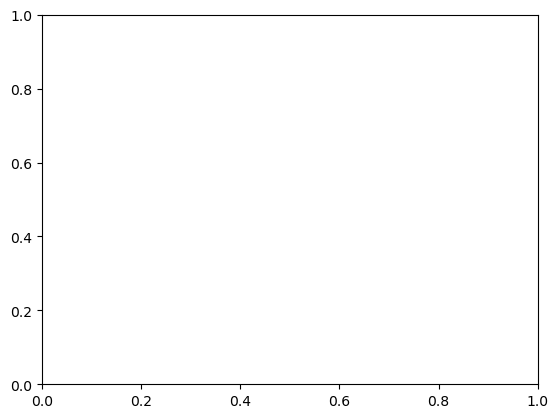

In [ ]:
plt.figure()
nx.draw_networkx_edges(G, pos=pos)

plt.show()

In [ ]:
model.cpu()(X[[1502]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4045,  1.1248,  3.8501,  0.4797, -1.4882, -2.3810,  0.7249, -2.2067,
         -0.1551,  0.3875, -1.3970]])

In [ ]:
model.cpu()(X[[16495]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.1636,  0.1775,  2.6569,  0.8054, -0.9038,  0.8106,  0.6587,  0.1596,
         -0.0127, -0.3620, -1.0718]])

In [ ]:
# lung cancer 
ELK_NERATINIB_A549 = explainer.explain(X[[18915]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[18915]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4355,  0.0196,  1.4991,  0.5416, -0.5329, -0.3395,  0.3494,  0.1289,
         -0.1935,  0.1341, -0.3573]])

In [ ]:
# melanoma (skin cancer)
ELK_NERATINIB_A375 = explainer.explain(X[[22366]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[22366]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.8208,  0.2433,  1.2894,  0.4925, -0.5565, -0.3107,  0.3159,  0.0357,
          0.0125,  0.3991, -1.0475]])

In [ ]:
ELK_NERATINIB_PC3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

source           target     score
10328  DRUG__BRD-K07955840  PROTEIN__P42345  0.978079
10702  DRUG__BRD-K52522949  PROTEIN__O15379  1.000000
10839  DRUG__BRD-K64606589  PROTEIN__O15379  0.999949
10861  DRUG__BRD-K68174511  PROTEIN__P42345  1.000000
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.000000

In [ ]:
ELK_NERATINIB_A549[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

source           target     score
11165  DRUG__BRD-K86797399  PROTEIN__O15379  0.999999

In [ ]:
BRD-K85606544

In [ ]:
src

array(['PROTEIN__P01106', 'PROTEIN__P42224', 'PROTEIN__P40763', ...,
       'MUT__Q9Y6I3', 'MUT__Q9Y6N6', 'MUT__Q9Y6W5'], dtype='<U19')

In [ ]:
sigidinfo[lambda x: x.pert_id == 'BRD-K61397605'][['pert_id', 'pert_dose', 'sig_id']]

pert_id  pert_dose                 sig_id
1010   BRD-K61397605   1.111110  REP.A015_A375_24H:P15
1665   BRD-K61397605   2.307690   REP.B015_PC3_24H:P13
1829   BRD-K61397605   2.307690  REP.B015_MCF7_24H:P13
2828   BRD-K61397605   0.769231  REP.B015_MCF7_24H:P14
3026   BRD-K61397605   0.256410  REP.B015_MCF7_24H:P15
...              ...        ...                    ...
26930  BRD-K61397605   0.085470   REP.B015_PC3_24H:P16
27088  BRD-K61397605   3.333330   REP.A015_PC3_24H:P14
27170  BRD-K61397605   0.041152   REP.A015_PC3_24H:P18
27607  BRD-K61397605  10.000000   LKCP001_U2OS_24H:D22
27700  BRD-K61397605  10.000000   LKCP001_MCF7_24H:D22

[61 rows x 3 columns]

# Example Plots 

Plot 3 different cell lines; same drug and dose. 

Target 

# GSNNExplainer Replicate Stability 

In [ ]:
xidx = 1665 
sig_ids[xidx]

'REP.B015_PC3_24H:P13'

In [ ]:
# tip: strong prior, big beta and run until it converges (lots of iters)

explainer = GSNNExplainer(model, data, hard=True, prior=2)
edgedf1 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
edgedf2 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
#edgedf2 = explainer.explain(X[[xidx]], targets=None, lr=1e-2, beta=1e-1, batch=25)

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5)

array([[14263,    53],
       [   45,  1453]])

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5) / len(edgedf1)

array([[0.90192235, 0.00335146],
       [0.00284558, 0.09188061]])

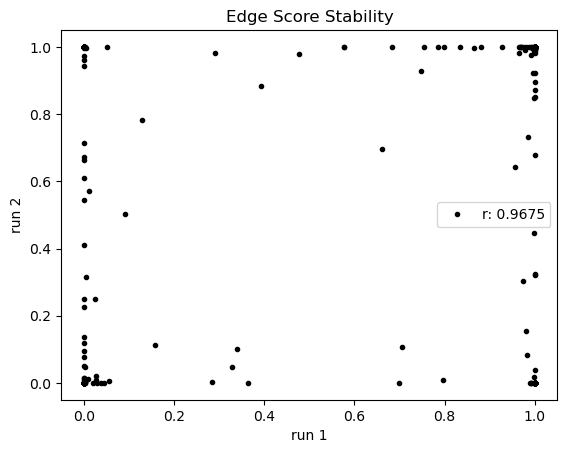

In [ ]:
plt.figure()
plt.plot(edgedf1.score, edgedf2.score, 'k.', label=f'r: {np.corrcoef(edgedf1.score, edgedf2.score)[0,1]:.4f}')
plt.xlabel('run 1')
plt.ylabel('run 2')
plt.title('Edge Score Stability')
plt.legend()
plt.show()

In [ ]:
subedges = edgedf1[lambda x: x.score > 0.5]
subnodes = np.unique(subedges.source.values.tolist() + subedges.target.values.tolist())
len(subnodes)

1157

In [ ]:
edgedf1[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

source           target         score
10758  DRUG__BRD-K61397605  PROTEIN__Q13547  1.000000e+00
10756  DRUG__BRD-K61397605  PROTEIN__O15379  9.999999e-01
10299  DRUG__BRD-K02130563  PROTEIN__Q92769  7.854854e-09
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.125857e-09
10759  DRUG__BRD-K61397605  PROTEIN__Q92769  1.099427e-09
10391  DRUG__BRD-K17743125  PROTEIN__O15379  4.231074e-10
10364  DRUG__BRD-K14529030  PROTEIN__P40763  3.779971e-10
10354  DRUG__BRD-K12867552  PROTEIN__O15379  3.115291e-10
10770  DRUG__BRD-K64052750  PROTEIN__O15264  3.001712e-10
10839  DRUG__BRD-K64606589  PROTEIN__O15379  2.639504e-10

In [ ]:
edgedf2[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

source           target         score
10758  DRUG__BRD-K61397605  PROTEIN__Q13547  1.000000e+00
10756  DRUG__BRD-K61397605  PROTEIN__O15379  9.225526e-01
10299  DRUG__BRD-K02130563  PROTEIN__Q92769  1.660771e-08
11165  DRUG__BRD-K86797399  PROTEIN__O15379  1.952612e-09
10759  DRUG__BRD-K61397605  PROTEIN__Q92769  9.561572e-10
10391  DRUG__BRD-K17743125  PROTEIN__O15379  4.841070e-10
10354  DRUG__BRD-K12867552  PROTEIN__O15379  4.203508e-10
10770  DRUG__BRD-K64052750  PROTEIN__O15264  3.101625e-10
10364  DRUG__BRD-K14529030  PROTEIN__P40763  3.055998e-10
10987  DRUG__BRD-K78431006  PROTEIN__O15264  2.711086e-10